In [1]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install -q wordcloud
import wordcloud
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [3]:
#Importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC

# Importing the warnings
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('/content/messages.csv')

In [5]:
df.head()

,subject,message,label
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0
1,NaN,"lang classification grimes , joseph e . and ba...",0
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0
3,risk,a colleague and i are researching the differin...,0
4,request book information,earlier this morning i was on the phone with a...,0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2893 entries, 0 to 2892
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   subject  2831 non-null   object
 1   message  2893 non-null   object
 2   label    2893 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 67.9+ KB


In [7]:
print('shape of dataset',df.shape)

shape of dataset (2893, 3)


In [8]:
df.isnull().sum()

subject    62
message     0
label       0
dtype: int64

In [9]:
print('count of label:\n', df['label'].value_counts())

count of label:
 0    2412
1     481
Name: label, dtype: int64


In [10]:
#Checking the Ratio of labels
print("Not a Spam Email Ratio i.e. 0 label:",round(len(df[df['label']==0])/len(df['label']),2)*100,"%")
print("Spam Email Ratio that is 1 label:",round(len(df[df['label']==1])/len(df['label']),2)*100,"%")

Not a Spam Email Ratio i.e. 0 label: 83.0 %
Spam Email Ratio that is 1 label: 17.0 %


In [11]:
df['length']=df.message.str.len()
df.head()

,subject,message,label,length
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0,2856
1,NaN,"lang classification grimes , joseph e . and ba...",0,1800
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0,1435
3,risk,a colleague and i are researching the differin...,0,324
4,request book information,earlier this morning i was on the phone with a...,0,1046


In [12]:
df['message']=df['message'].str.lower()
df.head()

,subject,message,label,length
0,job posting - apple-iss research center,content - length : 3386 apple-iss research cen...,0,2856
1,NaN,"lang classification grimes , joseph e . and ba...",0,1800
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas ( ...,0,1435
3,risk,a colleague and i are researching the differin...,0,324
4,request book information,earlier this morning i was on the phone with a...,0,1046


In [13]:
# Replace email addresses with 'email'
df['message'] = df['message'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$','emailaddress')
# Replace URLs with 'webaddress'
df['message'] = df['message'].str.replace(r'^http\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$','webaddress')
# Replace currency symbols with 'moneysymb' (£ can by typed with ALT key + 156)
df['message'] = df['message'].str.replace(r'£|\$', 'dollers')
# Replace 10 digit phone numbers (formats include paranthesis, spaces, no spaces, dashes) with 'phonenumber'
df['message'] = df['message'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$','phonenumber')
#replace numeric chars with 'numbr'
df['message'] = df['message'].str.replace(r'\d+(\.\d+)?', 'numbr')

In [14]:
#remove punctuations
df['message'] = df['message'].str.replace(r'[^\w\d\s]', ' ')
#replce whitespace btw terms with single space
df['message'] = df['message'].str.replace(r'\s+', ' ')
#remove leading and trailing whitesspace
df['message'] = df['message'].str.replace(r'^\s+|\s+?$', '')

In [15]:
df.head()

,subject,message,label,length
0,job posting - apple-iss research center,content length numbr apple iss research center...,0,2856
1,NaN,lang classification grimes joseph e and barbar...,0,1800
2,query : letter frequencies for text identifica...,i am posting this inquiry for sergei atamas sa...,0,1435
3,risk,a colleague and i are researching the differin...,0,324
4,request book information,earlier this morning i was on the phone with a...,0,1046


In [16]:
#remove stopwords
import string
import nltk
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english') + ['u', 'ü', 'ur', '4', '2', 'im', 'dont', 'doin', 'ure'])
df['message'] = df['message'].apply(lambda x: " ".join(term for term in x.split() if term not in stop_words))

In [17]:
#new column (clean_length) after punctuations, stopwords removal
df['clean_length'] = df.message.str.len()
df.head()

,subject,message,label,length,clean_length
0,job posting - apple-iss research center,content length numbr apple iss research center...,0,2856,2179
1,NaN,lang classification grimes joseph e barbara f ...,0,1800,1454
2,query : letter frequencies for text identifica...,posting inquiry sergei atamas satamas umabnet ...,0,1435,1064
3,risk,colleague researching differing degrees risk p...,0,324,210
4,request book information,earlier morning phone friend mine living south...,0,1046,629


In [18]:
#total length removal
print("Original Length:",df.length.sum())
print("Cleaned Length:",df.clean_length.sum())
print("Total Words Removed:",(df.length.sum()) - (df.clean_length.sum()))

Original Length: 9344743
Cleaned Length: 6767857
Total Words Removed: 2576886


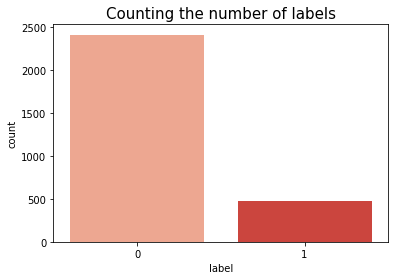

0    2412
1     481
Name: label, dtype: int64


In [19]:
#graphical viz for counting number of labels
plt.figure(figsize=(6,4))
sns.countplot(df['label'],palette= 'Reds')
plt.title("Counting the number of labels",fontsize=15)
plt.xticks(rotation='horizontal')
plt.show()
print(df.label.value_counts())

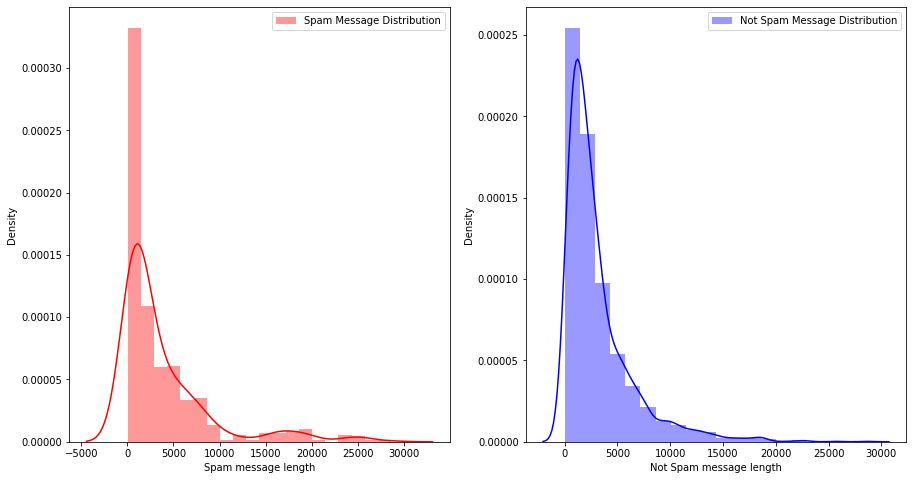

In [21]:
f,ax = plt.subplots(1,2,figsize=(15,8))

sns.distplot(df[df['label']==1]['length'],bins=20, ax=ax[0],label='Spam Message Distribution',color='r')
ax[0].set_xlabel('Spam message length')
ax[0].legend()

sns.distplot(df[df['label']==0]['length'],bins=20, ax=ax[1],label='Not Spam Message Distribution',color='b')
ax[1].set_xlabel('Not Spam message length')
ax[1].legend()

plt.show()

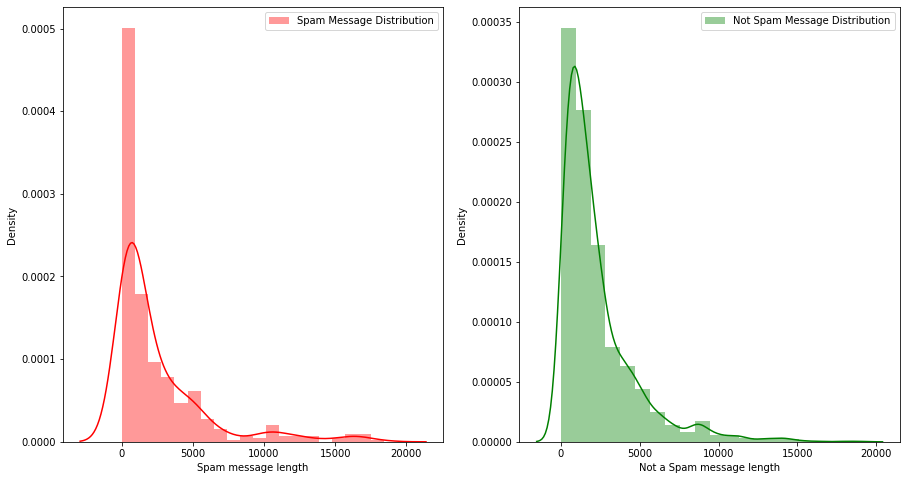

In [22]:
f,ax = plt.subplots(1,2,figsize=(15,8))

sns.distplot(df[df['label']==1]['clean_length'],bins=20, ax=ax[0],label='Spam Message Distribution',color='r')
ax[0].set_xlabel('Spam message length')
ax[0].legend()

sns.distplot(df[df['label']==0]['clean_length'],bins=20, ax=ax[1],label='Not Spam Message Distribution',color='g')
ax[1].set_xlabel('Not a Spam message length')
ax[1].legend()

plt.show()

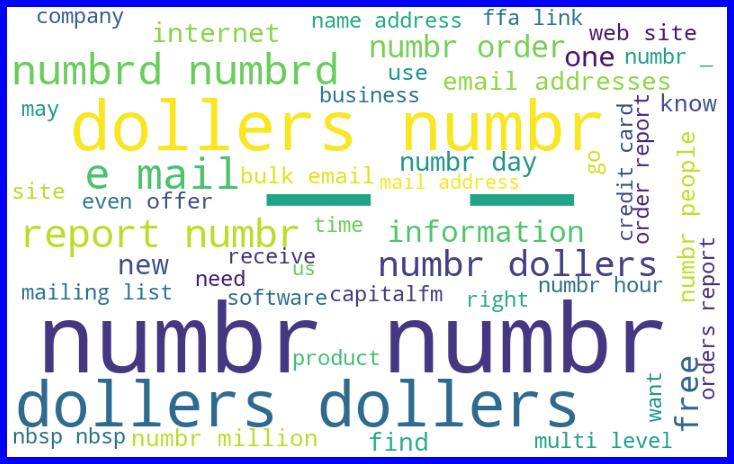

In [23]:
#Getting sense of loud words in spam 
from wordcloud import WordCloud


spams = df['message'][df['label']==1]

spam_cloud = WordCloud(width=800,height=500,background_color='white',max_words=50).generate(' '.join(spams))

plt.figure(figsize=(10,8),facecolor='b')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

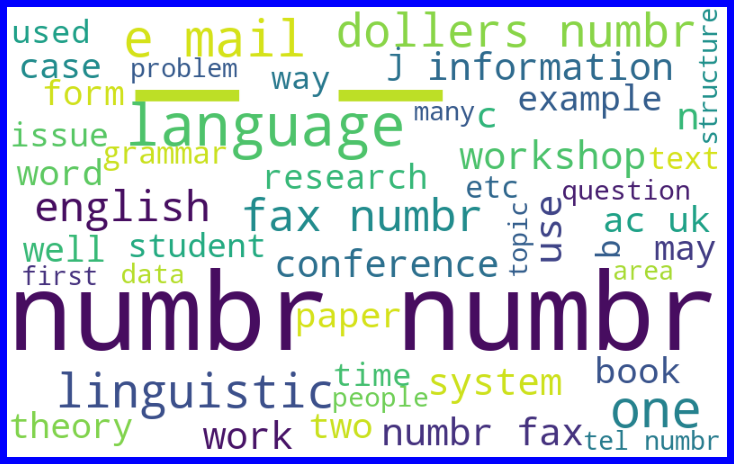

In [24]:
from wordcloud import WordCloud

not_spams = df['message'][df['label']==0]

spam_cloud = WordCloud(width=800,height=500,background_color='white',max_words=50).generate(' '.join(not_spams))

plt.figure(figsize=(10,8),facecolor='b')
plt.imshow(spam_cloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [25]:
# 1. Convert text into vectors using TF-IDF
# 2. Instantiate MultinomialNB classifier
# 3. Split feature and label

tf_vec = TfidfVectorizer()

#naive = MultinomialNB()

SVM = SVC(C=1.0, kernel='linear', degree=3 , gamma='auto')

features = tf_vec.fit_transform(df['message'])

X = features
y = df['label']

In [26]:

X_train,x_test,Y_train,y_test = train_test_split(X,y,random_state=42)         


SVM.fit(X_train,Y_train)
y_pred = SVM.predict(x_test)

print ('Final score = > ', accuracy_score(y_test,y_pred))

Final score = >  0.9875690607734806


In [27]:
y_pred

array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0,

In [28]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99       585
           1       0.99      0.94      0.97       139

    accuracy                           0.99       724
   macro avg       0.99      0.97      0.98       724
weighted avg       0.99      0.99      0.99       724



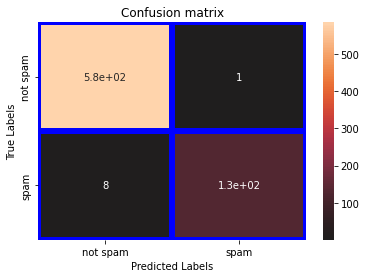

In [29]:

conf_mat = confusion_matrix(y_test,y_pred)

ax=plt.subplot()

sns.heatmap(conf_mat,annot=True,ax=ax,linewidths=5,linecolor='b',center=0)

ax.set_xlabel('Predicted Labels');ax.set_ylabel('True Labels')

ax.set_title('Confusion matrix')
ax.xaxis.set_ticklabels(['not spam','spam'])
ax.yaxis.set_ticklabels(['not spam','spam'])
plt.show()

In [30]:

import pickle
filename='Email_spam_detect.pkl'
M=open(filename,'wb')
pickle.dump(SVM,M)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           
M.close()